# Maximum Likelihood Expectation Maximization
Frequentist optimization of liklelihood surface

In [24]:
import lzma
from pathlib import Path

import dill as pickle
import numpy as np
from corner import corner
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import ipyparallel as ipp

In [3]:
from scipy.optimize import minimize

In [4]:
import elm

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [5]:
import rxmc

In [6]:
evidence_dir = Path("../evidence/data")
model_dir = Path("../model/")
likelihood_model_dir = Path("../likelihood_model/")
prior_path = Path("../prior/prior_distribution.pickle")

In [7]:
output_dir = Path("./elm_prior_propagation//")
output_dir.mkdir(parents=True, exist_ok=True)

## read in ELM prior parameter samples

In [8]:
with open(prior_path, "rb") as f:
    prior = pickle.load(f)
prior_samples = prior.rvs(1000)

## read in observations

In [9]:
with lzma.open(evidence_dir / "nn_elastic_observations.xz", "rb") as f:
    nn_elastic_obs = pickle.load(f)
with lzma.open(evidence_dir / "pp_elastic_observations.xz", "rb") as f:
    pp_elastic_obs = pickle.load(f)

## read in physical models

In [10]:
with open(model_dir / "elm_nn_model.pkl", "rb") as f:
    elm_nn_model = pickle.load(f)

In [11]:
with open(model_dir / "elm_pp_model.pkl", "rb") as f:
    elm_pp_model = pickle.load(f)

## read in likelihood models

In [12]:
with open(likelihood_model_dir / "likelihood_model.pkl", "rb") as f:
    likelihood_model = pickle.load(f)

## Set up Evidence object

In [13]:
pp_constraints = [
    rxmc.constraint.Constraint(
        observations=obs,
        physical_model=elm_pp_model,
        likelihood_model=likelihood_model,
    )
    for entry_id, obs in pp_elastic_obs.items()
]
nn_constraints = [
    rxmc.constraint.Constraint(
        observations=obs,
        physical_model=elm_nn_model,
        likelihood_model=likelihood_model,
    )
    for entry_id, obs in nn_elastic_obs.items()
]

In [14]:
evidence = rxmc.evidence.Evidence(constraints=nn_constraints + pp_constraints)

## Run MLEM

In [15]:
bounds = [p.bounds for p in elm.params]
bounds

[(30, 80),
 (0, 30),
 (20, 50),
 (0, 60),
 (-10, 60),
 (-10, 60),
 (-0.4, -0.3),
 (-0.01, 0.01),
 (10, 60),
 (10, 60),
 (0.9, 1.5),
 (0.9, 1.5),
 (0.4, 1.0),
 (0.4, 1.0)]

In [17]:
good_samples = np.concatenate(
    [np.load("/home/kyle/db/chex_calibration/results/qe_cal_samples.npy")]
)
mask = np.ones(15, dtype=bool)
mask[6] = False
good_starting_point = np.mean(good_samples[:, mask], axis=0)
good_ssample_stdev = np.std(good_samples[:, mask], axis=0)

In [19]:
%%timeit
evidence.log_likelihood(prior.mean)

714 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%time
result = minimize(
    lambda x: -evidence.log_likelihood(x),
    good_starting_point,
    bounds=bounds,
)

CPU times: user 57min 47s, sys: 2h 12min 52s, total: 3h 10min 40s
Wall time: 40min 58s


In [26]:
with open("mlem_result.pkl", "wb") as f:
    pickle.dump(result, f)

In [22]:
result

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3726.8152111890013
        x: [ 5.856e+01  1.313e+01 ...  6.827e-01  4.000e-01]
      nit: 165
      jac: [ 2.901e+02  6.736e+00 ...  3.255e+01  4.333e+03]
     nfev: 3045
     njev: 203
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>

In [23]:
for p, x in zip(elm.params, result.x):
    print(p.name, x)

V0 58.55591865715508
W0 13.128584399203723
Wd0 27.46031121569972
V1 29.738738486951725
W1 18.984950037214787
Wd1 31.445486969794384
alpha -0.4
beta 0.001205198662327965
gamma_w 53.012306964455114
gamma_d 22.302359243943215
r0A 1.1772649712925054
r1A 1.3928079671660771
a0 0.6826645674404013
a1 0.4


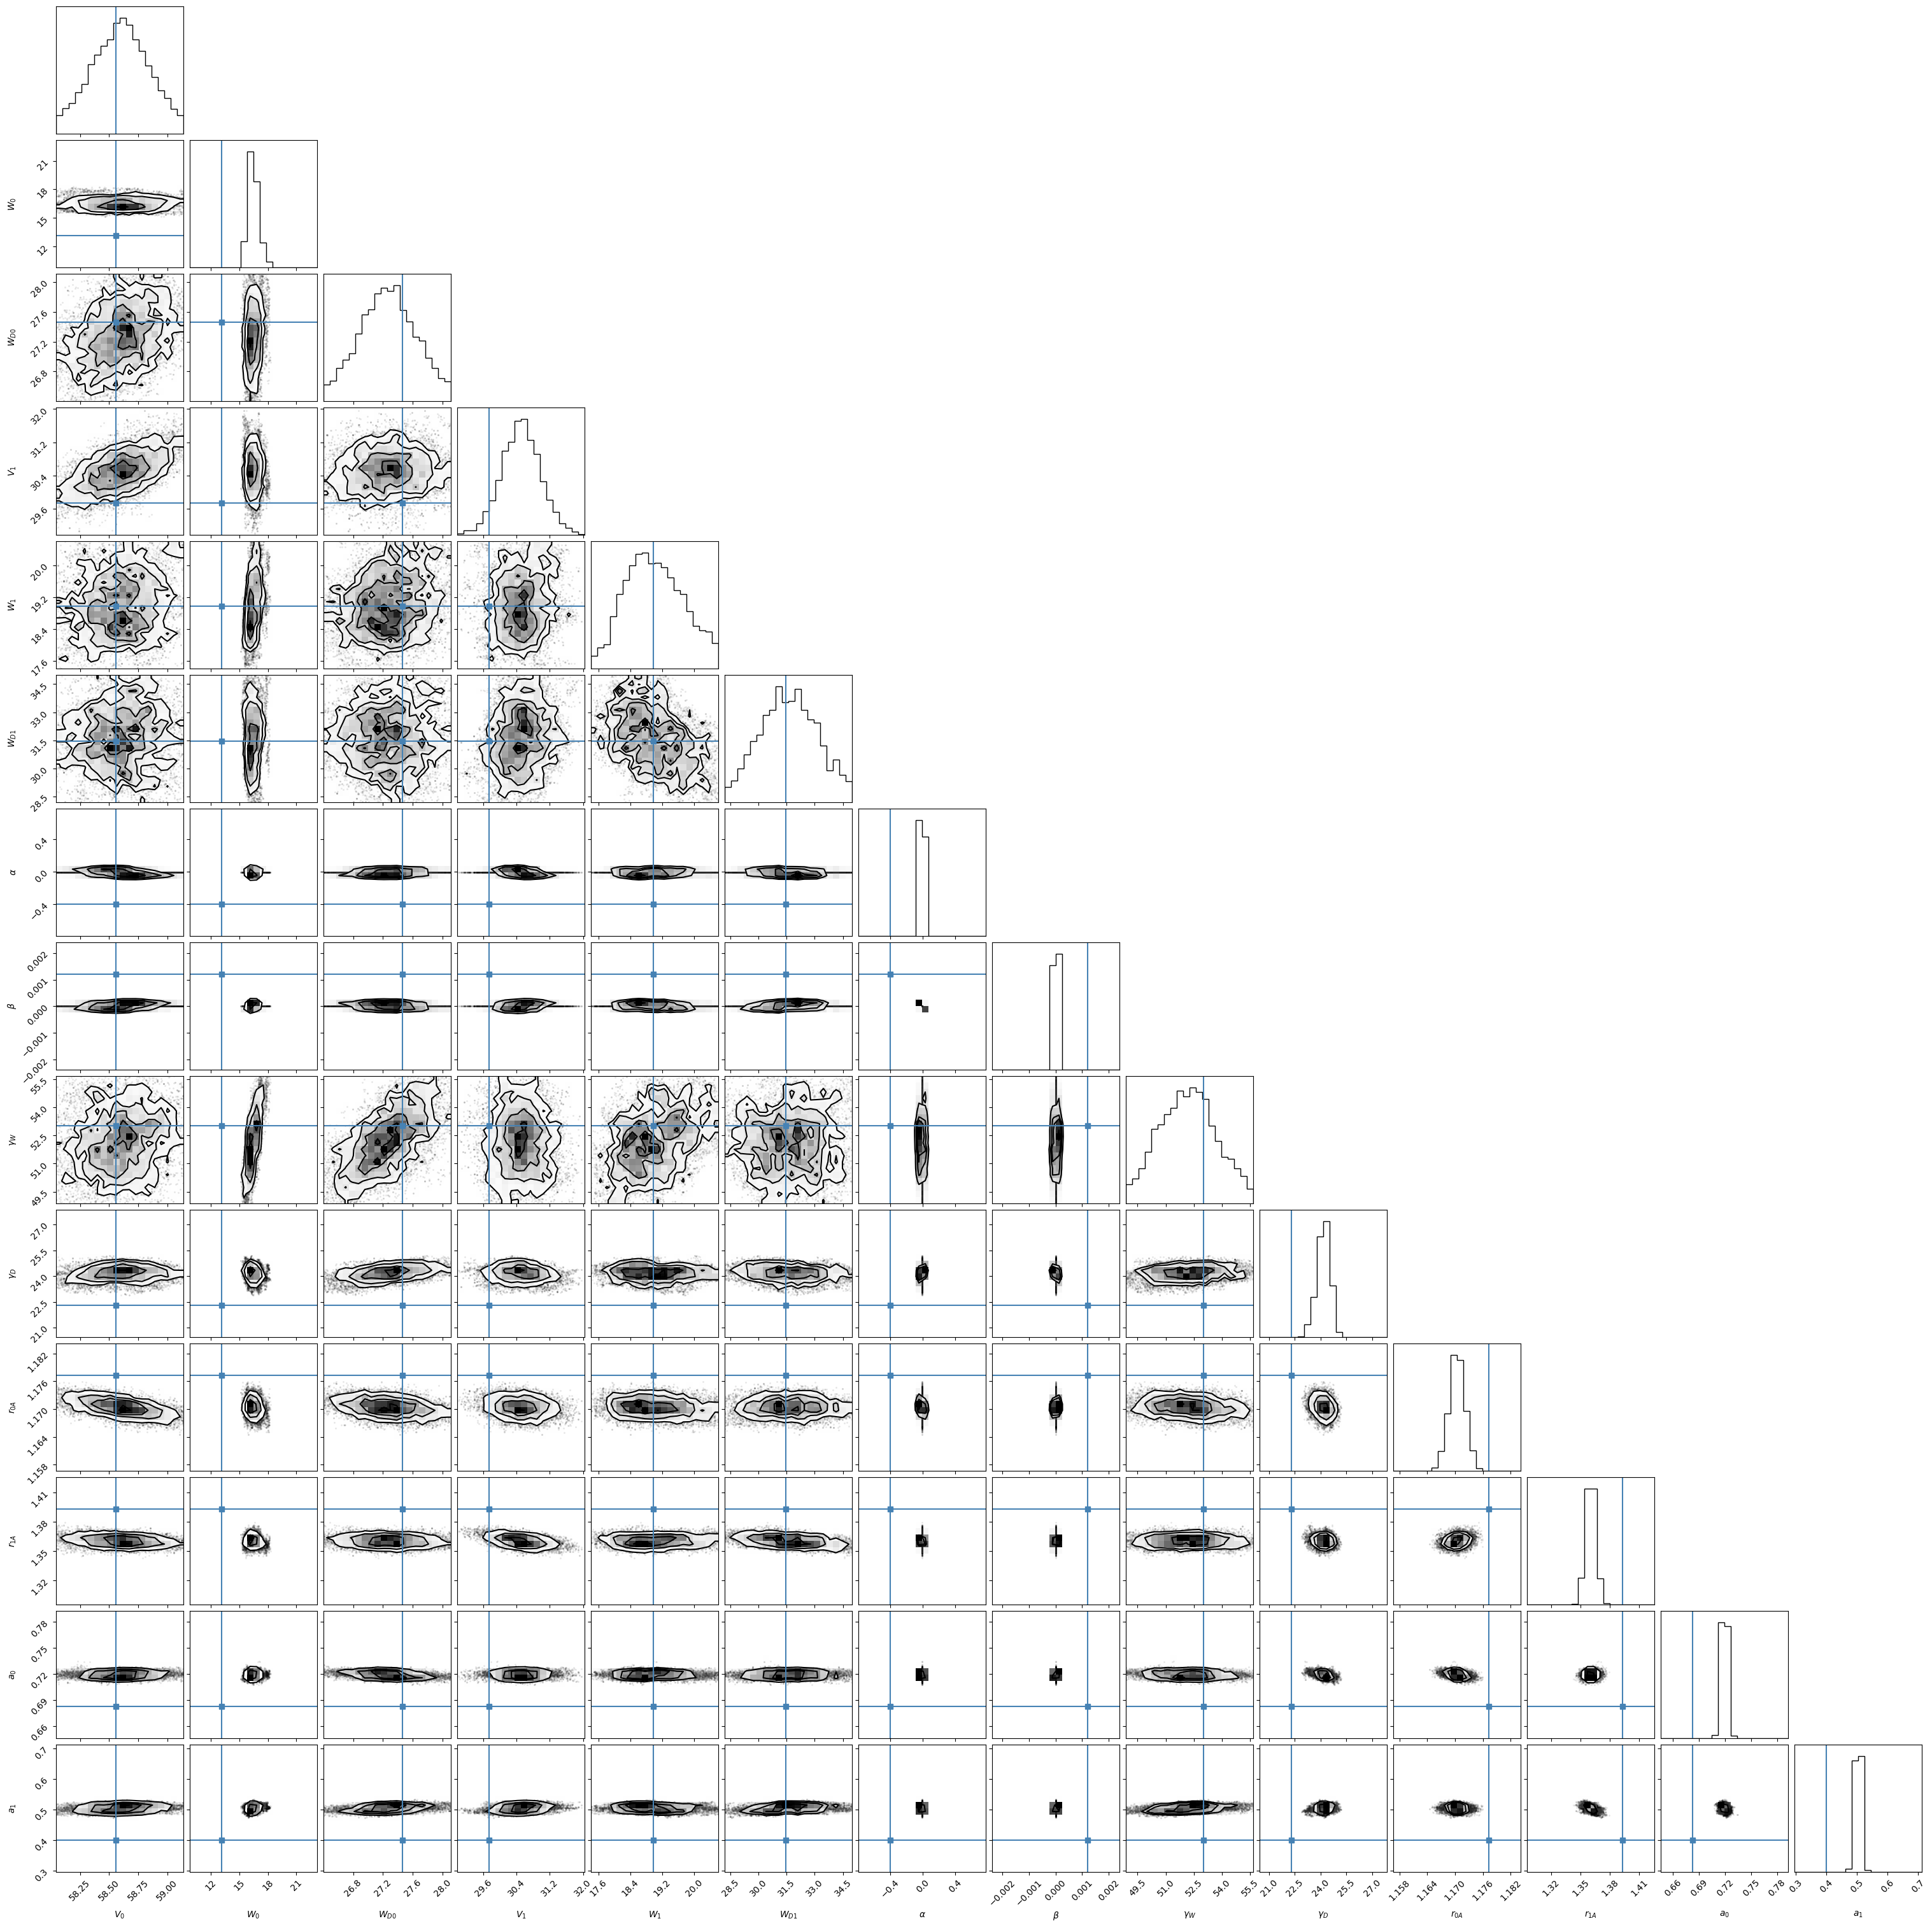

In [42]:
x0 = np.mean(good_samples[:, mask], axis=0)
std = np.std(good_samples[:,mask], axis=0)
delta = np.max( np.array([ np.abs(x0 - result.x), std]), axis=0)
ranges = [ (x- d*2, x+d*2) for x,d in zip(x0,delta) ]

c = corner(
    good_samples[:, mask],
    truths=result.x,
    labels=[f"${p.latex_name}$" for p in elm.params],
    range=ranges,
    
)